In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTImageProcessor
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nyynctal
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nyynctal
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=26d9c1a4ac4e1b3050d69df854ba13e4440a1f11b12b6e68689fb2231aa65d35
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7f8zuco/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


# Read data from database

In [ ]:
data_train_path = "/content/drive/MyDrive/UIT/Năm 4/CS406/DATASET/train"
data_dev_path = "/content/drive/MyDrive/UIT/Năm 4/CS406/DATASET/dev"
data_test_path = "/content/drive/MyDrive/UIT/Năm 4/CS406/DATASET/test"

In [ ]:
def read_data(data_path):
  dct = {
      'image_path': [],
      'label': []
  }
  for folder in os.listdir(data_path):
    folder_path = data_path + "/" + folder
    for img in os.listdir(folder_path):
      image_path = folder_path + "/" + img
      dct['image_path'].append(image_path)
      dct['label'].append(folder)
      df_ = pd.DataFrame(dct)
  return df_

In [ ]:
dct_train = read_data(data_train_path)
dct_dev = read_data(data_dev_path)
dct_test = read_data(data_test_path)

In [ ]:
df = pd.DataFrame(dct_train)
df.head()

,image_path,label
0,/content/drive/MyDrive/UIT/Năm 4/CS406/DATASE...,11
1,/content/drive/MyDrive/UIT/Năm 4/CS406/DATASE...,11
2,/content/drive/MyDrive/UIT/Năm 4/CS406/DATASE...,11
3,/content/drive/MyDrive/UIT/Năm 4/CS406/DATASE...,11
4,/content/drive/MyDrive/UIT/Năm 4/CS406/DATASE...,11


In [ ]:
df_combined = pd.concat([dct_train, dct_test], ignore_index=True)
df_combined = shuffle(df_combined)

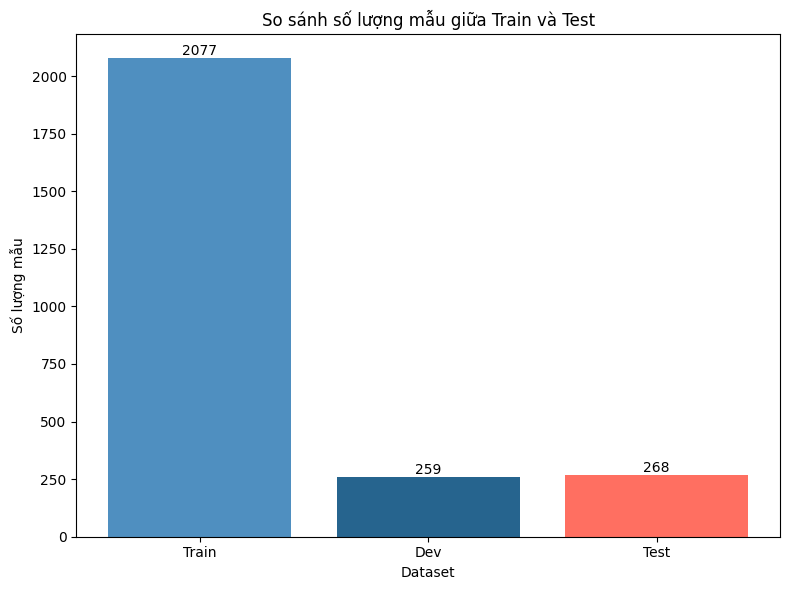

In [ ]:
import matplotlib.pyplot as plt

train_size = len(dct_train)
dev_size = len(dct_dev)
test_size = len(dct_test)

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
bars = plt.bar(['Train', 'Dev', 'Test'], [train_size, dev_size, test_size], color=['#4F8FC0', '#26648E', '#FF6F61'])

# Ghi số lượng vào mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, str(yval), ha='center', va='bottom')

plt.xlabel('Dataset')
plt.ylabel('Số lượng mẫu')
plt.title('So sánh số lượng mẫu giữa Train và Test')

plt.tight_layout()
plt.show()

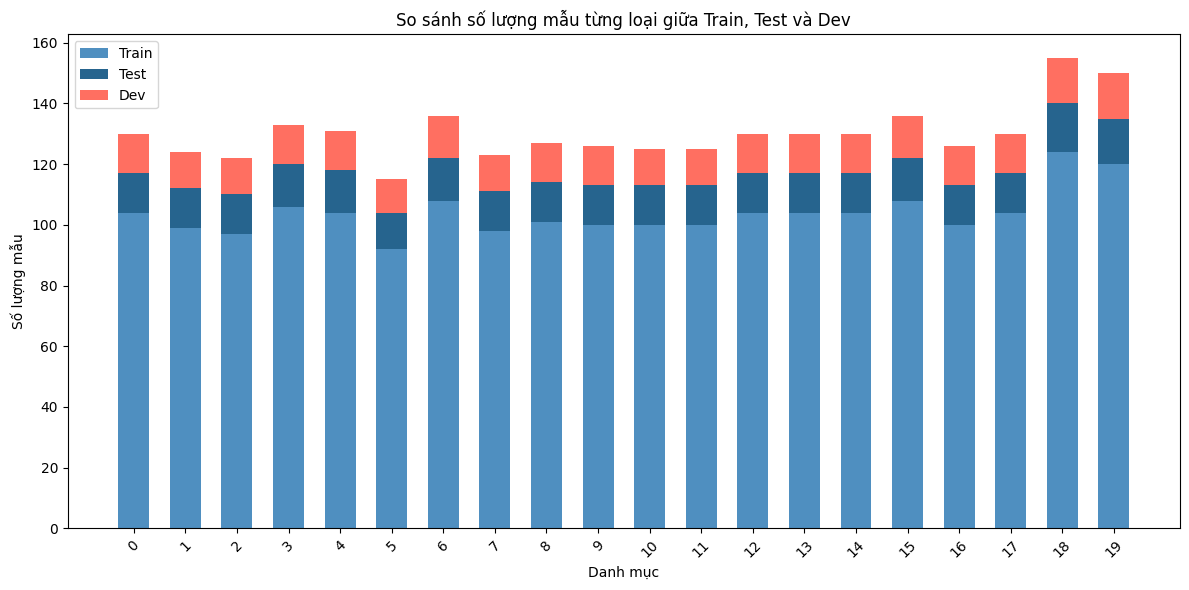

In [ ]:
import matplotlib.pyplot as plt

# Chuyển đổi giá trị trong category từ kiểu string sang kiểu số (int hoặc float nếu cần)
train_counts = dct_train['label'].astype(int).value_counts().sort_index()  # Chuyển đổi sang int và sắp xếp
test_counts = dct_test['label'].astype(int).value_counts().sort_index()  # Chuyển đổi sang int và sắp xếp
dev_counts = dct_dev['label'].astype(int).value_counts().sort_index()  # Chuyển đổi sang int và sắp xếp cho dev

# Đảm bảo các category đều khớp nhau
all_categories = train_counts.index.union(test_counts.index).union(dev_counts.index)
train_counts = train_counts.reindex(all_categories, fill_value=0)
test_counts = test_counts.reindex(all_categories, fill_value=0)
dev_counts = dev_counts.reindex(all_categories, fill_value=0)

# Sắp xếp lại theo thứ tự tăng dần (theo giá trị số)
all_categories = sorted(all_categories, key=int)  # Sắp xếp theo giá trị số

# Vẽ biểu đồ cột chồng
plt.figure(figsize=(12, 6))
bar_width = 0.6  # Điều chỉnh chiều rộng của cột
index = range(len(all_categories))

# Vẽ cột cho train, test và dev
plt.bar(index, train_counts.loc[all_categories], bar_width, label='Train', color='#4F8FC0')
plt.bar(index, test_counts.loc[all_categories], bar_width, bottom=train_counts.loc[all_categories], label='Test', color='#26648E')
plt.bar(index, dev_counts.loc[all_categories], bar_width, bottom=train_counts.loc[all_categories] + test_counts.loc[all_categories], label='Dev', color='#FF6F61')

plt.xlabel('Danh mục')
plt.ylabel('Số lượng mẫu')
plt.title('So sánh số lượng mẫu từng loại giữa Train, Test và Dev')
plt.xticks(index, all_categories, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


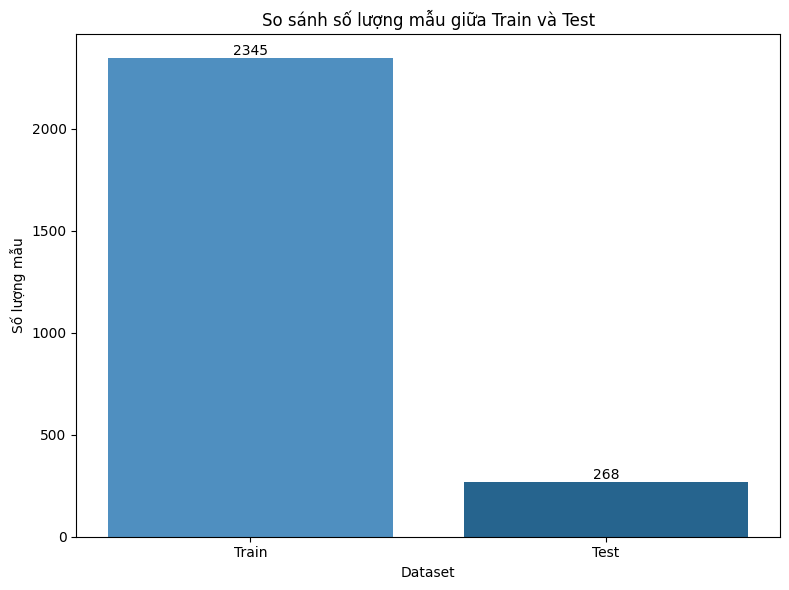

In [ ]:
import matplotlib.pyplot as plt

train_size = len(df_combined)
test_size = len(dct_test)

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
bars = plt.bar(['Train', 'Test'], [train_size, test_size], color=['#4F8FC0', '#26648E'])

# Ghi số lượng vào mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, str(yval), ha='center', va='bottom')

plt.xlabel('Dataset')
plt.ylabel('Số lượng mẫu')
plt.title('So sánh số lượng mẫu giữa Train và Test')

plt.tight_layout()
plt.show()

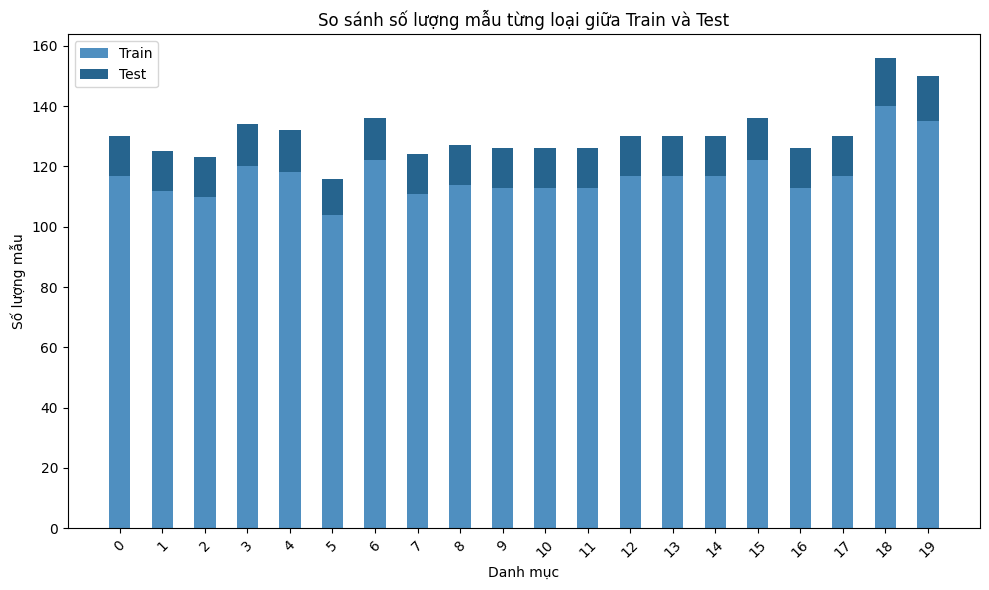

In [ ]:
import matplotlib.pyplot as plt

# Chuyển đổi giá trị trong category từ kiểu string sang kiểu số (int hoặc float nếu cần)
train_counts = df_combined['label'].astype(int).value_counts().sort_index()  # Chuyển đổi sang int và sắp xếp
test_counts = dct_test['label'].astype(int).value_counts().sort_index()  # Chuyển đổi sang int và sắp xếp

# Đảm bảo các category đều khớp nhau
all_categories = train_counts.index.union(test_counts.index)
train_counts = train_counts.reindex(all_categories, fill_value=0)
test_counts = test_counts.reindex(all_categories, fill_value=0)

# Sắp xếp lại theo thứ tự tăng dần (theo giá trị số)
all_categories = sorted(all_categories, key=int)  # Sắp xếp theo giá trị số

# Vẽ biểu đồ cột chồng
plt.figure(figsize=(10, 6))
bar_width = 0.5
index = range(len(all_categories))

# Vẽ cột cho train và test
plt.bar(index, train_counts.loc[all_categories], bar_width, label='Train', color='#4F8FC0')
plt.bar(index, test_counts.loc[all_categories], bar_width, bottom=train_counts.loc[all_categories], label='Test', color='#26648E')

plt.xlabel('Danh mục')
plt.ylabel('Số lượng mẫu')
plt.title('So sánh số lượng mẫu từng loại giữa Train và Test')
plt.xticks(index, all_categories, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
df_combined['label'].value_counts()

,count
label,
18,140
19,135
6,122
15,122
3,120
4,118
17,117
0,117
12,117


# Load model

In [ ]:
import torch
from transformers import ViTModel, ViTImageProcessor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from torchvision import models, transforms
import pandas as pd

# Kiểm tra GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Loading Resnet50 model

In [ ]:
# 1. Load mô hình ResNet-50
model_type = "Resnet50"
resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = torch.nn.Identity()  # Loại bỏ lớp FC để lấy đặc trưng
resnet_model.to(device)
resnet_model.eval()

# 2. Xử lý ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize ảnh về kích thước 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Loading ViT model

In [ ]:

model_type = "ViT"
# 1. Load mô hình ViT
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
vit_model.to(device)
vit_model.eval()

# 2. Xử lý ảnh
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize ảnh về kích thước 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=img_feature_extractor.image_mean, std=img_feature_extractor.image_std)
])


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Loading CLIP

In [ ]:
# 1. Load mô hình ResNet-50
from transformers import CLIPProcessor, CLIPModel
model_type = "CLIP"

# Load model và processor
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# Extract Feature

In [ ]:
if model_type == "ViT":
  model = vit_model
elif model_type == "Resnet50":
  model = resnet_model
elif model_type == "CLIP":
  model = clip_model

In [ ]:

# 3. Dataset tùy chỉnh
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx] if self.labels is not None else -1
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# 4. Trích xuất đặc trưng từ ViT
def extract_features(dataloader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = model(pixel_values=images)
            cls_features = outputs.last_hidden_state[:, 0, :]  # Lấy vector CLS
            features.append(cls_features.cpu())
            labels.extend(lbls)
    return torch.cat(features), labels

# 4. Trích xuất đặc trưng từ ResNet-50
def extract_features_resnet50(dataloader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = model(images)  # Lấy đặc trưng
            features.append(outputs.cpu())
            labels.extend(lbls)
    return torch.cat(features), labels



# 5. Tìm ảnh tương tự
def find_top_k_similar(query_image_path, dataset_features, dataset_labels, model, transform, k=5):
    query_image = Image.open(query_image_path).convert("RGB")
    query_image = transform(query_image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_feature = model(pixel_values=query_image).last_hidden_state[:, 0, :].cpu()

    similarities = cosine_similarity(query_feature.numpy(), dataset_features.numpy())[0]
    top_k_indices = np.argsort(similarities)[-k:][::-1]

    return [(i, dataset_labels[i], similarities[i]) for i in top_k_indices]


def find_top_k_similar_resnet50(query_image_path, dataset_features, dataset_labels, model, transform, k=5):
    query_image = Image.open(query_image_path).convert("RGB")
    query_image = transform(query_image).unsqueeze(0).to(device)
    with torch.no_grad():
        query_feature = model(query_image).cpu()

    similarities = cosine_similarity(query_feature.numpy(), dataset_features.numpy())[0]
    top_k_indices = np.argsort(similarities)[-k:][::-1]

    return [(i, dataset_labels[i], similarities[i]) for i in top_k_indices]


# 6. Demo sử dụng với DataFrame
def load_data_from_dataframe(df, image_column, label_column, transform):
    image_paths = df[image_column].tolist()
    labels = df[label_column].tolist()
    dataset = ImageDataset(image_paths, labels, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    return dataloader




In [ ]:
# Ví dụ DataFrame


# Trích xuất đặc trưng
dataloader = load_data_from_dataframe(df_combined, 'image_path', 'label', transform)

dataset_features, dataset_labels = extract_features_resnet50(dataloader, model)

## CLIP retrieval

In [ ]:
# Define a function to preprocess an image
def preprocess_image(image):
    return processor(images=image, return_tensors="pt", padding=True)

# Create a transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
from PIL import Image

# Load and preprocess an image
image_path = "/content/drive/MyDrive/UIT/Năm 4/CS406/DATASET/test/11/img_11_107.jpg"
image = Image.open(image_path)

from PIL import Image
import torch

def preprocess_image(image_path):
    image = Image.open(image_path)
    return processor(images=image, return_tensors="pt", padding=True)
all_image_features = []

for path in dct_test["image_path"]:
    inputs = preprocess_image(path)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        normalized_features = image_features / image_features.norm(dim=-1, keepdim=True)  # Normalize
        all_image_features.append(normalized_features)

# Combine all features into a tensor
all_image_features = torch.cat(all_image_features, dim=0)

# Preprocess and encode a query image
query_image_path = "/content/drive/MyDrive/UIT/Năm 4/CS406/DATASET/test/11/img_11_107.jpg"
query_inputs = preprocess_image(query_image_path)
with torch.no_grad():
    query_feature = model.get_image_features(**query_inputs)
    query_feature = query_feature / query_feature.norm(dim=-1, keepdim=True)  # Normalize

# Compute similarity
similarity = torch.matmul(query_feature, all_image_features.T)  # Cosine similarity
top_k = 5  # Number of similar images to retrieve
retrieved_indices = similarity.topk(top_k, dim=1).indices

print("Retrieved indices:", retrieved_indices)

Retrieved indices: tensor([[ 8,  1, 11,  6,  4]])


# Experiment for query image

# Test query for input image

In [ ]:
# Tìm top 5 ảnh tương tự cho một query ảnh
query_image_path = "/content/drive/MyDrive/UIT/Năm 4/CS406/DATASET/test/11/img_11_107.jpg"
top_k_results = find_top_k_similar_resnet50(query_image_path, dataset_features, dataset_labels, model, transform, k=50)

# In kết quả
for idx, label, similarity in top_k_results:
    print(f"Image Index: {idx}, Label: {label}, Similarity: {similarity:.4f}")

Image Index: 666, Label: 11, Similarity: 1.0000
Image Index: 1670, Label: 11, Similarity: 0.9238
Image Index: 837, Label: 11, Similarity: 0.8943
Image Index: 386, Label: 11, Similarity: 0.8931
Image Index: 1122, Label: 11, Similarity: 0.8867
Image Index: 520, Label: 11, Similarity: 0.8843
Image Index: 714, Label: 11, Similarity: 0.8742
Image Index: 1139, Label: 11, Similarity: 0.8739
Image Index: 733, Label: 11, Similarity: 0.8727
Image Index: 1148, Label: 11, Similarity: 0.8717
Image Index: 1452, Label: 11, Similarity: 0.8701
Image Index: 1958, Label: 11, Similarity: 0.8688
Image Index: 2280, Label: 11, Similarity: 0.8679
Image Index: 1654, Label: 9, Similarity: 0.8660
Image Index: 1840, Label: 11, Similarity: 0.8644
Image Index: 154, Label: 11, Similarity: 0.8630
Image Index: 202, Label: 11, Similarity: 0.8607
Image Index: 832, Label: 11, Similarity: 0.8600
Image Index: 1945, Label: 11, Similarity: 0.8594
Image Index: 1543, Label: 11, Similarity: 0.8577
Image Index: 120, Label: 11, S

# Evaluation

## Load data from test set

In [ ]:
# Load tập  test
test_dataloader = load_data_from_dataframe(dct_test, 'image_path', 'label', transform)

# Trích xuất đặc trưng từ tập test
dataset_features_test, dataset_labels_test = extract_features_resnet50(test_dataloader, model)

In [ ]:
dataset_features_test.shape

torch.Size([268, 2048])

In [ ]:

# Tìm top 5 ảnh tương tự cho một query ảnh trong tập train
query_image_path = "/content/drive/MyDrive/UIT/Năm 4/CS406/DATASET/test/11/img_11_107.jpg"
top_k_results = find_top_k_similar_resnet50(query_image_path, dataset_features, dataset_labels, model, transform, k=5)

# In kết quả
for idx, label, similarity in top_k_results:
    print(f"Image Index: {idx}, Label: {label}, Similarity: {similarity:.4f}")

Image Index: 666, Label: 11, Similarity: 1.0000
Image Index: 1670, Label: 11, Similarity: 0.9238
Image Index: 837, Label: 11, Similarity: 0.8943
Image Index: 386, Label: 11, Similarity: 0.8931
Image Index: 1122, Label: 11, Similarity: 0.8867


## Compute mAP for evaluation on test set

In [ ]:
# Hàm tính mAP@K cho từng truy vấn
def compute_map_at_k_per_query(query_results, ground_truth, k):
    """
    Tính điểm Mean Average Precision (mAP@K) cho các kết quả truy vấn của mô hình, riêng lẻ cho từng truy vấn.

    Parameters:
    - query_results (list of tuples): Mỗi tuple chứa (index, label, similarity) của kết quả tìm kiếm cho một truy vấn.
    - ground_truth (list): Các nhãn thực của tập dữ liệu.
    - k (int): Số lượng ảnh hàng đầu cần xem xét.

    Returns:
    - mAP@K: Điểm Mean Average Precision tại K.
    """
    all_ap = []
    for idx, label, _ in query_results[:k]:
        if ground_truth == label:
            all_ap.append(1)
        else:
            all_ap.append(0)

    # Tính Precision at K cho từng truy vấn
    precision_at_k = np.cumsum(all_ap) / (np.arange(1, k + 1))
    mAP_at_k = np.mean(precision_at_k) if all_ap else 0.0  # Đảm bảo mAP@K không báo lỗi khi không có ảnh hàng đầu nào phù hợp

    return mAP_at_k


In [ ]:
query_results_per_query = []
for image_path in dct_test["image_path"]:
  top_k_results = find_top_k_similar_resnet50(image_path, dataset_features_test, dataset_labels_test, model, transform, k=5)
  query_result = []
  for idx, label, similarity in top_k_results:
    query_result.append((idx, label, similarity))
  query_results_per_query.append(query_result)

## For ViT model

In [ ]:
# Tính toán mAP@K cho từng truy vấn
k = 5
mAP_at_k_per_query = []
i = 0
for query_results in query_results_per_query:
    mAP_at_k_per_query.append(compute_map_at_k_per_query(query_results, dataset_labels_test[i], k))
    i += 1  # Tăng `i` lên 1 đơn vị
mean_mAP_at_k = np.mean(mAP_at_k_per_query)

print(f"Mean mAP@{k} across all queries: {mean_mAP_at_k}")

Mean mAP@5 across all queries: 0.9182960199004975


## For Resnet50 model

In [ ]:
# Tính toán mAP@K cho từng truy vấn
k = 5
mAP_at_k_per_query = []
i = 0
for query_results in query_results_per_query:
    mAP_at_k_per_query.append(compute_map_at_k_per_query(query_results, dataset_labels_test[i], k))
    i += 1  # Tăng `i` lên 1 đơn vị
mean_mAP_at_k = np.mean(mAP_at_k_per_query)

print(f"Mean mAP@{k} across all queries: {mean_mAP_at_k}")

Mean mAP@5 across all queries: 0.8833955223880597
